In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
import pandas as pd
import vaex as vx
from sklearn.metrics.pairwise import cosine_similarity
import requests
import shutil
from PIL import Image
import config
import os
import time
import glob

## Preprocessing steps

In [2]:
dfl = pd.read_csv('Data/link.csv')
dfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


In [3]:
dfl.dropna(inplace=True)
dfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27026 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27026 non-null  int64  
 1   imdbId   27026 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 844.6 KB


In [4]:
dfm = pd.read_csv('Data/movie.csv')
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [5]:
df_tmid=dfm.merge(dfl,on='movieId').drop(['imdbId'],axis=1)
df_tmid.head()

,movieId,title,genres,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,31357.0
4,5,Father of the Bride Part II (1995),Comedy,11862.0


In [6]:
dfr = pd.read_csv('Data/rating.csv')
dfr.drop(['timestamp'],axis=1,inplace=True)
dfr.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [7]:
preFinalDf= df_tmid.merge(dfr,on='movieId').drop(['movieId'],axis=1)
preFinalDf.head()

,title,genres,tmdbId,userId,rating
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,3,4.0
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,6,5.0
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,8,4.0
3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,10,4.0
4,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,11,4.5


In [8]:
df = preFinalDf['genres']
a =[]
for i in df.unique():
    b=[word for word in i.split('|')]
    a.extend(b)
    
print(len(set(a)))

20


In [9]:
%%time
print(set(a))

{'Action', 'Western', 'Romance', 'Horror', 'War', 'Musical', 'Crime', 'Sci-Fi', 'Animation', 'Film-Noir', 'Adventure', 'Thriller', '(no genres listed)', 'Comedy', 'IMAX', 'Mystery', 'Documentary', 'Children', 'Fantasy', 'Drama'}
CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
total_genres = 18 # removed Film-Noir && (no genres listed)

In [10]:
%%time
vu=preFinalDf.groupby('userId').count()['rating']>600
validUsers= vu[vu].index

CPU times: total: 3.02 s
Wall time: 3.03 s


In [11]:
validUsers.shape

(5325,)

In [12]:
ppDf = preFinalDf[preFinalDf['userId'].isin(validUsers)]
ppDf.shape

(5396026, 5)

In [13]:
vm=ppDf.groupby('tmdbId').count()['rating']>500
validMovie = vm[vm].index

In [14]:
validMovie.shape

(2828,)

In [15]:
ppDf2 = ppDf[ppDf['tmdbId'].isin(validMovie)]
ppDf2.shape

(4098762, 5)

In [16]:
ppDf2.head()

,title,genres,tmdbId,userId,rating
18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,54,4.0
19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,58,5.0
27,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,91,4.0
37,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,116,3.0
56,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,156,5.0


In [17]:
nppDf2 = ppDf2.copy()
nppDf2.head()

,title,genres,tmdbId,userId,rating
18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,54,4.0
19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,58,5.0
27,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,91,4.0
37,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,116,3.0
56,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862.0,156,5.0


In [20]:
nppDf2=nppDf2.astype({"tmdbId": int})
nppDf2.head()

,title,genres,tmdbId,userId,rating
18,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,54,4.0
19,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,58,5.0
27,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,91,4.0
37,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,116,3.0
56,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,862,156,5.0


In [18]:
ppDf2.drop(['title','genres'],axis=1, inplace=True)
ppDf2.head()

C:\Users\abhinav kumar\AppData\Local\Temp\ipykernel_6804\3672254860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppDf2.drop(['title','genres'],axis=1, inplace=True)


,tmdbId,userId,rating
18,862.0,54,4.0
19,862.0,58,5.0
27,862.0,91,4.0
37,862.0,116,3.0
56,862.0,156,5.0


In [19]:
ppDf2 = ppDf2.astype({"tmdbId": int})
ppDf2.head()

,tmdbId,userId,rating
18,862,54,4.0
19,862,58,5.0
27,862,91,4.0
37,862,116,3.0
56,862,156,5.0


In [21]:
finalDf = ppDf2.pivot_table(index='tmdbId',columns='userId',values='rating')
finalDf.head()

userId,54,58,91,104,116,156,208,247,271,294,...,138211,138254,138270,138301,138307,138325,138382,138397,138406,138437
tmdbId,,,,,,,,,,,,,,,,,,,,,
5,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,4.5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
11,4.0,NaN,4.5,3.0,4.5,NaN,4.5,4.0,2.5,4.0,...,4.0,4.5,4.0,3.5,2.0,5.0,4.0,3.5,4.0,5.0
12,NaN,NaN,4.0,NaN,3.0,NaN,3.5,NaN,2.5,4.5,...,4.5,4.0,NaN,3.5,NaN,4.0,NaN,NaN,4.0,4.0
13,5.0,4.5,4.0,NaN,4.0,5.0,1.0,4.0,3.5,4.5,...,5.0,4.0,4.0,3.5,NaN,4.5,5.0,4.5,4.0,NaN
14,5.0,4.5,4.5,2.0,4.5,5.0,3.5,4.0,NaN,3.5,...,5.0,4.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,5.0


In [54]:
movieId = pd.DataFrame(columns=['tmdbId','title'])
l=[]
for i in finalDf.index:
    a = {'tmdbId':[i], 'title':nppDf2.loc[nppDf2.loc[nppDf2['tmdbId']==i].index[0]]['title']}
    a= pd.DataFrame(a)
    movieId= pd.concat([movieId,a],axis=0)

In [56]:
movieId.shape

(2828, 2)

In [58]:
movieId.to_csv('movieId.csv')

In [59]:
finalDf.fillna(0,inplace=True)
finalDf.shape

(2828, 5325)

In [60]:
finalDf.head()

userId,54,58,91,104,116,156,208,247,271,294,...,138211,138254,138270,138301,138307,138325,138382,138397,138406,138437
tmdbId,,,,,,,,,,,,,,,,,,,,,
5,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,4.0,0.0,4.5,3.0,4.5,0.0,4.5,4.0,2.5,4.0,...,4.0,4.5,4.0,3.5,2.0,5.0,4.0,3.5,4.0,5.0
12,0.0,0.0,4.0,0.0,3.0,0.0,3.5,0.0,2.5,4.5,...,4.5,4.0,0.0,3.5,0.0,4.0,0.0,0.0,4.0,4.0
13,5.0,4.5,4.0,0.0,4.0,5.0,1.0,4.0,3.5,4.5,...,5.0,4.0,4.0,3.5,0.0,4.5,5.0,4.5,4.0,0.0
14,5.0,4.5,4.5,2.0,4.5,5.0,3.5,4.0,0.0,3.5,...,5.0,4.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,5.0


In [30]:
finalDf.to_csv('recomderData.csv')

In [37]:
vax_df = vx.from_pandas(finalDf)

In [38]:
vax_df.export_hdf5('recomderData.hdf5')

In [2]:
%%time
df = vx.open('recomderData.hdf5')

CPU times: total: 2 s
Wall time: 5.05 s


## Predict similar movies when one movie is provided using cosine similarity

In [61]:
movieSimilarity = cosine_similarity(finalDf)

In [62]:
def getSimilarMovie(movieNo):
    a=sorted(list(enumerate(movieSimilarity[movieNo])),key= lambda x:x[1], reverse=True)[1:6]
    l=[]
    for i in a:
        l.append(finalDf.index[i[0]])
    return l

In [63]:
pd.DataFrame(movieSimilarity).to_csv('cosineSimilarityMovie.csv')

In [61]:
getSimilarMovie(5)

[289, 935, 275, 238, 567]

In [78]:
pURL = "https://api.themoviedb.org/3/movie/"
endUrl = "?api_key="+config.apiKey+"&language=en-US"
URL = pURL+str(935)+endUrl
r = requests.get(url = URL)
data = r.json()
iUrl ="http://image.tmdb.org/t/p/w500"+data['poster_path']
ir = requests.get(url=iUrl,stream=True)
with open('img.jpg', 'wb') as out_file:
    shutil.copyfileobj(ir.raw, out_file)

## Using NN for describing movie content

In [3]:
df.shape

(2828, 5325)

In [34]:
x = tf.Variable(tf.random.uniform(shape=[df.shape[0],total_genres-1],minval=0, maxval=10, dtype=tf.float32, seed=12345))
x = tf.Variable(tf.concat([x, tf.ones([df.shape[0], 1], tf.float32)], 1))
print(x.shape)
w = tf.Variable(tf.random.uniform(shape=[total_genres,df.shape[1]], maxval=5, dtype=tf.float32, seed=54321))
print(w.shape)

(2828, 18)
(18, 5325)


In [12]:
y = tf.constant(df,dtype=tf.float32)
print(y.shape)

(2828, 5325)


In [35]:
alpha =0.01
opti= Adam(learning_rate=alpha)
iter =400
c=[]
for i in range(iter):
    with tf.GradientTape() as tape:
        #mean normalised yhat
        f = tf.matmul(x, w)
        
        cost = tf.math.pow((f-y),2)/y.shape[0]
        
    c.append(tf.reduce_sum(cost)/y.shape[0])
    grad = tape.gradient(cost,[x,w])
    # print(grad[0])
    opti.apply_gradients(zip(grad,[x,w])) # adma optimizer

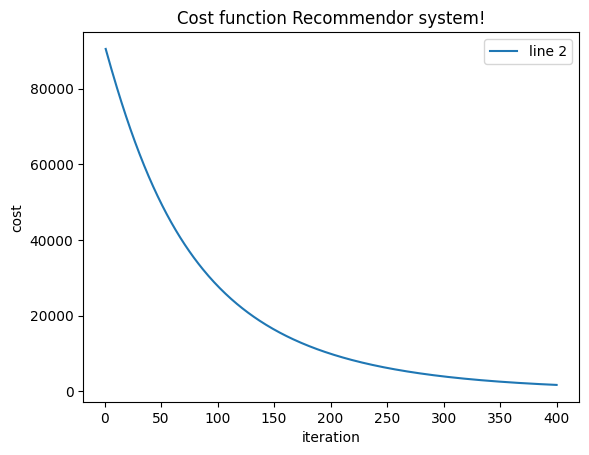

In [36]:
l=np.arange(1,len(c)+1)
plt.plot(l, c, label = "line 2")
  
# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('cost')
# giving a title to my graph
plt.title('Cost function Recommendor system!')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

## save X and w in file 

In [37]:
ad = x.numpy()

In [38]:
np.savetxt('X.csv',ad,delimiter = ',')

In [39]:
wd = w.numpy()
np.savetxt('weightsUser.csv',wd,delimiter=',')

In [42]:
xnew  =  pd.read_csv('X.csv', header=None)
xnew.shape

(2828, 18)

In [43]:
xnew.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,5.682322,-0.897780,3.752467,-0.185753,1.248515,6.022859,8.085154,0.112789,2.261771,-0.884071,-0.701015,7.462840,6.453860,-0.298246,-1.099492,2.960825,6.801059,-1.150281
1,6.317095,0.309381,7.985845,1.851497,6.837043,2.493290,3.698485,7.961789,5.841898,5.397579,6.945214,-0.949645,3.510865,7.041460,3.653907,-1.001987,-0.714953,-1.207193
2,4.208190,0.295290,2.045042,4.872062,1.336962,4.683116,4.992603,2.394806,0.436266,0.872684,6.732273,6.117455,0.594963,4.648324,2.072190,1.714708,0.104830,-1.121464
3,2.055705,5.093465,7.872066,1.452390,6.032907,7.049561,1.963313,0.813673,-0.862250,1.558668,5.844586,2.323023,6.597925,5.497945,6.672180,0.709606,-0.758779,-1.177634
4,7.643218,2.781130,6.733648,1.063475,-0.826374,7.020107,0.377517,-1.333094,-0.638358,5.535422,-0.057857,4.864127,-1.238528,2.764988,8.193514,-0.223204,6.035557,-1.113933


In [44]:
xnew.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000,2828.000000
mean,3.425964,3.365048,3.410636,3.318536,3.300119,3.302739,3.328499,3.434276,3.324749,3.421609,3.413495,3.421297,3.478396,3.436781,3.340442,3.388586,3.451523,-1.199157
std,2.825173,2.805546,2.868805,2.838707,2.788197,2.810287,2.798844,2.817931,2.790599,2.827400,2.780111,2.827387,2.784440,2.839948,2.836666,2.842038,2.851699,0.063597
min,-1.531867,-1.554505,-1.560976,-1.527883,-1.549638,-1.538502,-1.533382,-1.532998,-1.549081,-1.553385,-1.538167,-1.501283,-1.519392,-1.534886,-1.541972,-1.565739,-1.568902,-1.348377
25%,0.963940,0.929652,0.924172,0.861019,0.882444,0.916168,0.884625,0.982946,0.886685,0.936954,0.998460,0.968570,1.072549,0.903328,0.894191,0.968179,0.928288,-1.243284
50%,3.418524,3.386122,3.495283,3.303006,3.261637,3.253008,3.408094,3.473769,3.281237,3.399160,3.500240,3.475277,3.544851,3.433681,3.272659,3.428198,3.540002,-1.207068
75%,5.814363,5.784618,5.860878,5.761202,5.711599,5.815103,5.715620,5.870425,5.733836,5.892346,5.766829,5.834312,5.872688,5.881553,5.755502,5.795337,5.944896,-1.163941
max,8.275949,8.279468,8.279078,8.275426,8.264864,8.259027,8.270165,8.285139,8.277187,8.257163,8.250052,8.271597,8.273499,8.266366,8.267680,8.268434,8.283567,-0.775862


In [121]:
l=[]
for i in  xnew.index:
    data=xnew.loc[i]
    data = np.array(data)
    data = np.reshape(data, (1,18))
    a= cosine_similarity(data,[[2.4,2,4.7,5.3,4,2.6,4.3,5.5,6.1,7.3,8.3,4.5,2.4,4.4,3.4,6.5,3.0,-0.1]])[0][0]
    l.append(a)

In [122]:
ade = sorted(list(enumerate(l)),key= lambda x:x[1], reverse=True)[1:6]

In [123]:
ade

[(1785, 0.929959818252406),
 (1694, 0.923936945632521),
 (609, 0.9173922019180943),
 (737, 0.9113849787923497),
 (2731, 0.9104966140985685)]

In [116]:
finalDf =  pd.read_csv('recomderData.csv',index_col='tmdbId')

In [117]:
finalDf.head()

,54,58,91,104,116,156,208,247,271,294,...,138211,138254,138270,138301,138307,138325,138382,138397,138406,138437
tmdbId,,,,,,,,,,,,,,,,,,,,,
5,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
11,4.0,0.0,4.5,3.0,4.5,0.0,4.5,4.0,2.5,4.0,...,4.0,4.5,4.0,3.5,2.0,5.0,4.0,3.5,4.0,5.0
12,0.0,0.0,4.0,0.0,3.0,0.0,3.5,0.0,2.5,4.5,...,4.5,4.0,0.0,3.5,0.0,4.0,0.0,0.0,4.0,4.0
13,5.0,4.5,4.0,0.0,4.0,5.0,1.0,4.0,3.5,4.5,...,5.0,4.0,4.0,3.5,0.0,4.5,5.0,4.5,4.0,0.0
14,5.0,4.5,4.5,2.0,4.5,5.0,3.5,4.0,0.0,3.5,...,5.0,4.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,5.0


In [124]:
ld=[]
for i in ade:
        ld.append(finalDf.index[i[0]])
print(ld)        

[10395, 10112, 1359, 1809, 37135]


In [127]:
time_to_wait = 20
time_counter = 0
for i in ld:
    pURL = "https://api.themoviedb.org/3/movie/"
    endUrl = "?api_key="+config.apiKey+"&language=en-US"
    URL = pURL+str(i)+endUrl
    r = requests.get(url = URL)
    data = r.json()
    iUrl ="http://image.tmdb.org/t/p/w500"+data['poster_path']
    ir = requests.get(url=iUrl,stream=True)
    with open('img_'+str(i)+'.jpg', 'wb') as out_file:
        shutil.copyfileobj(ir.raw, out_file)
    while not os.path.exists('img_'+str(i)+'.jpg'):
        time.sleep(1)
        time_counter += 1
        if time_counter > time_to_wait:break  

In [128]:
import glob
files = glob.glob('*.jpg')
for i in files:
    os.remove(i)